In [39]:
# Common imports
import numpy as np
import os
import pandas as pd
import time

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [40]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


In [41]:
PREPROCESSED_X_PATH = './data/preprocessed_X.pkl'
PREPROCESSED_Y_PATH = './data/preprocessed_y.pkl'

In [42]:
from sklearn.utils import shuffle

X = np.load(PREPROCESSED_X_PATH)
y = np.load(PREPROCESSED_Y_PATH)

print("Initial shape: ", X.shape)

#reshaping each sample to a vector due DNN architecture
X = np.reshape(X,(len(X), -1))

print("Reshaped: ", X.shape)

X, y = shuffle(X, y)

#Split into train, test and validation data
X_train = np.array(X[:int(len(X)*0.7)], dtype=np.float32)
y_train = np.array(y[:int(len(y)*0.7)], dtype=np.float32)

X_test = np.array(X[int(len(X)*0.9):], dtype=np.float32)
y_test = np.array(y[int(len(y)*0.9):], dtype=np.float32)

X_valid = np.array(X[int(len(X)*0.7):int(len(X)*0.9)], dtype=np.float32)
y_valid = np.array(y[int(len(y)*0.7):int(len(y)*0.9)], dtype=np.float32)

Initial shape:  (3214, 12, 80, 1)
Reshaped:  (3214, 960)


In [43]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
import tensorflow as tf
import numpy as np
import random

he_init = tf.contrib.layers.variance_scaling_initializer()

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=150, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)

        # needed in case of early stopping
        max_checks_without_progress = 100
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        self.loss_values = []
        self.acc_values = []
        self.best_loss_values = []

        # extra ops for batch normalization
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    self.loss_values.append(loss_val)
                    self.acc_values.append(acc_val)
                    self.best_loss_values.append(best_loss)
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

    def accuracy_score(self, X_test, y_test):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            X_test_reshaped = np.reshape(X_test,(len(X_test), -1))
            acc_test = self._accuracy.eval(feed_dict={self._X: X_test_reshaped, self._y: y_test})
            print("Final accuracy on test set:", acc_test)

            return acc_test

    def restore(self, path, X, y):
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)

        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)

        self._session = tf.Session(graph=self._graph)
        
        self._saver.restore(self._session, path)

In [48]:
%%time

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

dnnClassifier = DNNClassifier(n_hidden_layers=3, learning_rate=0.1, n_neurons=300, 
                              optimizer_class=tf.train.AdagradOptimizer,batch_size=400, 
                              activation=leaky_relu(), dropout_rate=0.1)
dnnClassifier.fit(X_train, y_train, n_epochs=300, X_valid=X_valid, y_valid=y_valid)

0	Validation loss: 2.913406	Best loss: 2.913406	Accuracy: 30.02%
1	Validation loss: 2.700262	Best loss: 2.700262	Accuracy: 22.08%
2	Validation loss: 2.350586	Best loss: 2.350586	Accuracy: 29.24%
3	Validation loss: 2.097689	Best loss: 2.097689	Accuracy: 37.48%
4	Validation loss: 1.545915	Best loss: 1.545915	Accuracy: 52.41%
5	Validation loss: 1.437833	Best loss: 1.437833	Accuracy: 53.34%
6	Validation loss: 1.738676	Best loss: 1.437833	Accuracy: 49.30%
7	Validation loss: 1.334279	Best loss: 1.334279	Accuracy: 57.85%
8	Validation loss: 1.204025	Best loss: 1.204025	Accuracy: 61.90%
9	Validation loss: 1.258052	Best loss: 1.204025	Accuracy: 61.90%
10	Validation loss: 1.054906	Best loss: 1.054906	Accuracy: 64.85%
11	Validation loss: 0.936595	Best loss: 0.936595	Accuracy: 68.12%
12	Validation loss: 1.233947	Best loss: 0.936595	Accuracy: 61.90%
13	Validation loss: 0.920868	Best loss: 0.920868	Accuracy: 69.36%
14	Validation loss: 0.970451	Best loss: 0.920868	Accuracy: 67.81%
15	Validation loss: 

130	Validation loss: 0.596219	Best loss: 0.508354	Accuracy: 84.91%
131	Validation loss: 0.556461	Best loss: 0.508354	Accuracy: 85.85%
132	Validation loss: 0.552369	Best loss: 0.508354	Accuracy: 85.69%
133	Validation loss: 0.580377	Best loss: 0.508354	Accuracy: 85.23%
134	Validation loss: 0.623849	Best loss: 0.508354	Accuracy: 84.14%
135	Validation loss: 0.642545	Best loss: 0.508354	Accuracy: 83.36%
136	Validation loss: 0.599340	Best loss: 0.508354	Accuracy: 85.54%
137	Validation loss: 0.571668	Best loss: 0.508354	Accuracy: 86.47%
138	Validation loss: 0.634951	Best loss: 0.508354	Accuracy: 85.38%
139	Validation loss: 0.562760	Best loss: 0.508354	Accuracy: 86.00%
140	Validation loss: 0.596711	Best loss: 0.508354	Accuracy: 85.07%
141	Validation loss: 0.590797	Best loss: 0.508354	Accuracy: 86.94%
142	Validation loss: 0.575338	Best loss: 0.508354	Accuracy: 86.00%
143	Validation loss: 0.592482	Best loss: 0.508354	Accuracy: 85.07%
144	Validation loss: 0.602012	Best loss: 0.508354	Accuracy: 85

In [49]:
dnnClassifier.accuracy_score(X_test, y_test)

Final accuracy on test set: 0.85714287


0.85714287

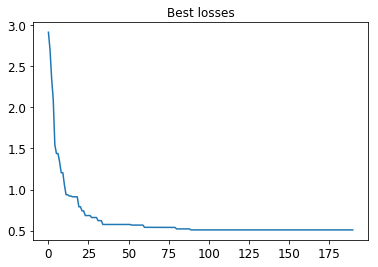

In [50]:
plt.plot(dnnClassifier.best_loss_values)
plt.title('Best losses')
plt.show()

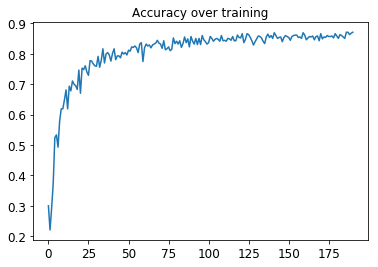

In [51]:
plt.plot(dnnClassifier.acc_values)
plt.title('Accuracy over training')
plt.show()